# Implement a circuit that returns $\lvert01\rangle$ and $\lvert10\rangle$ with equal probability (50% for each)

In [1]:
from qiskit import *
%matplotlib inline
import matplotlib.pyplot as plt
from qiskit.visualization import *
import numpy as np

#### Using H, X, CX gates we can make this circuit as following:

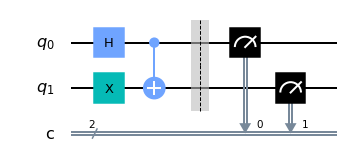

In [15]:
q = QuantumCircuit(2,2)

q.x(1)
q.h(0)
q.cx(0,1)
q.barrier(range(2))
q.measure((0,1),(0,1))

q.draw('mpl')

{'01': 511, '10': 513}


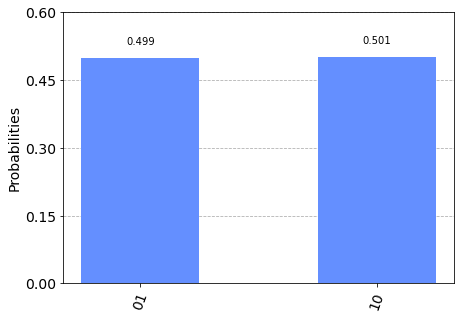

In [10]:
backend = Aer.get_backend('qasm_simulator')
job = execute(q, backend, shots= 1024)
result = job.result()
count = result.get_counts()
print(count)
plot_histogram(count)

[0.+0.j 1.+0.j 0.+0.j 0.+0.j]


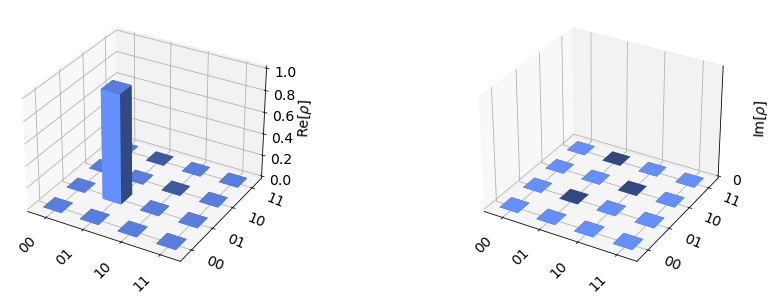

In [19]:
backend = Aer.get_backend('statevector_simulator')
job = execute(q, backend)
result = job.result()
state = result.get_statevector(q, decimals=3)
print(state)
plot_state_city(state)

### The circuit should consist only of CNOTs, RXs and RYs.

So using $RX$, $RY$ gates with 'fixed' parameters we can translate the previous circuit. Pauli $X$ gate is equivalent to $RX$ gate for angle $\pi$ [2]. And $H$ gate can be written as a combination of the $RX$ and $RY$ gates with specific parameters i.e. $H \equiv RY (−\pi/2)*RX(\pi)$ [1].

We can translate the circuit as follows.

>Reference:<br>
1. Maslov, Dmitri. "Basic circuit compilation techniques for an ion-trap quantum machine." New Journal of Physics 19.2 (2017): 023035.
https://arxiv.org/pdf/1603.07678.pdf
2. https://quantum-computing.ibm.com/docs/iqx/operations-glossary#x-gate

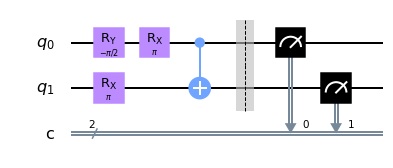

In [6]:
qc = QuantumCircuit(2,2)

# qc.rx(np.pi,0)
qc.rx(np.pi,1)
qc.ry((-np.pi/2),0)
qc.rx(np.pi,0)
qc.cx(0,1)
qc.barrier(range(2))
qc.measure((0,1),(0,1))

qc.draw('mpl')

{'01': 513, '10': 511}


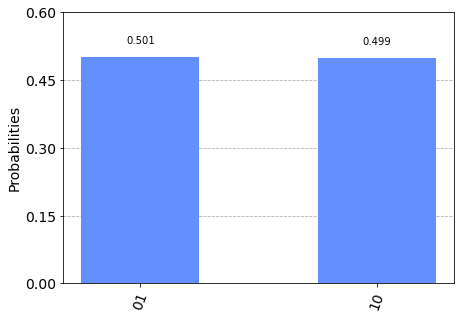

In [7]:
backend = Aer.get_backend('qasm_simulator')
jobs = execute(qc, backend, shots= 1024)
results = jobs.result()
counts = results.get_counts()
print(counts)
plot_histogram(counts)

### But we have to find the right set of parameters being equal to 0 or randomly chosen using gradient descent.

**Also, <i>simulations must be done with sampling (i.e. a limited number of measurements per iteration) and noise</i>.**

At first, we need to write the functions for creating the circuit and measuring the outcomes. Then we can get the probabilities from the results. We will then calculate the cost by putting all of it together and then apply optimizer to  the cost function in order to find the proper parameters.

In [40]:
from qiskit.aqua.components.optimizers.aqgd import AQGD
from qiskit.aqua.components.optimizers.adam_amsgrad import ADAM
from qiskit.aqua.components.optimizers.nelder_mead import NELDER_MEAD
import qiskit.providers.aer.noise as noise

In [9]:
# initializing the circuit with RX, RY and CX gates

def circuit(params):
    
    circ = QuantumCircuit(2,2)
    
    circ.rx(params[0],1)
    circ.ry(params[1],0)
    circ.rx(params[2],0)
    circ.cx(0,1)
    
    circ.barrier(range(2))
    circ.measure((0,1),(0,1))
    
    return circ
    

In [10]:
# getting the circuit measurements

def counts( circ, shot):
    
    # defining backend 
    backend = Aer.get_backend('qasm_simulator')
    
    # adding noise
    noise_model = noise.NoiseModel()
    
    job = execute(circ, backend, shots=shot, noise_model=noise_model)
    result = job.result()
    count = result.get_counts()
    
        
    return count

In [11]:
# getting probabilities for each of 00, 01, 10, 11 

def probabilities(count,shots):
    
    p00 = 0
    p01 = 0
    p10 = 0
    p11 = 0
    
    if '00' in count.keys():
        p00 = count['00']/shots*100
    
    if '01' in count.keys():
        p01 = count['01']/shots*100
    
    if '10' in count.keys():
        p10 = count['10']/shots*100
            
    if '11' in count.keys():
        p11 = count['11']/shots*100
    
        
    costs = ((0-p00)**2 + (50-p01)**2 + (50-p10)**2 + (0-p11)**2)
        
        
    return costs

In [12]:
# putting all of it together and computing cost of the circuit for certain shots

class compute_cost:
    
    def cost(self, params):

        cir = circuit(params)

        count = counts(cir,self.shot)

        costs = probabilities(count,self.shot)

        return costs

So in this phase, three built in optimizer functions provided by Qiskit are used to optimize the parameters of $RX$ and $RY$ gates. These are:
1. Analytic Quantum Gradient Descent optimizer (AQGD)
2. Adam Optimizer
3. Nelder-Mead Optimizer

## Analytic Quantum Gradient Descent optimizer (AQGD)

In [14]:

optimizer1 = AQGD(maxiter=5000, eta=1.0, tol=1e-03, disp=False, momentum=0.30)

#sampling
shots=[1,10,100,1000]

step_no = 100

min_aqgd_costs = []

for shot_no in shots:
    cost_obj = compute_cost()
    cost_obj.shot = shot_no
    
    print('Shot no: ',shot_no)
    
    aqgd_optimizer_costs = []
    minimum_cost = 1000000.0
    minimum_param = []
        
    for i in range(step_no):  
        init = np.random.rand(3)
        param = optimizer1.optimize(num_vars=3, objective_function=cost_obj.cost, initial_point=init)
        if (i+1)%20 ==0 and i:
            print('parameters: ',param[0],'cost: ',param[1],' after ',i+1,' iterations')
        aqgd_optimizer_costs.append(param)
        if param[1] <= 1.00:
            break
    
    
    for par in aqgd_optimizer_costs:
        if par[1] < minimum_cost:
            minimum_cost = par[1]
            minimum_param = list(par[0])
            
    min_aqgd_costs.append(minimum_param)

Shot no:  1
parameters:  [0.06225051 0.3576299  0.70946909] cost:  15000.0  after  20  iterations
parameters:  [0.55017495 0.4088281  0.48687366] cost:  15000.0  after  40  iterations
parameters:  [0.4353572  0.68911647 0.55297156] cost:  15000.0  after  60  iterations
parameters:  [ 8.05083511e+03 -8.04906358e+03  7.81293082e-01] cost:  5000.0  after  80  iterations
parameters:  [0.11276505 0.17960144 0.70678609] cost:  15000.0  after  100  iterations
Shot no:  10
Shot no:  100
Shot no:  1000


In [23]:
print(min_aqgd_costs)

[[17962.888333610754, -39.11853682406306, 18037.133025191313], [-37627.42181854431, 16556.605280609852, -6705.713963433021], [-241710.76203728616, -19411.450346255002, 31297.80973131755], [169089.31992842988, -85.11638914662029, 8649.629765587024]]


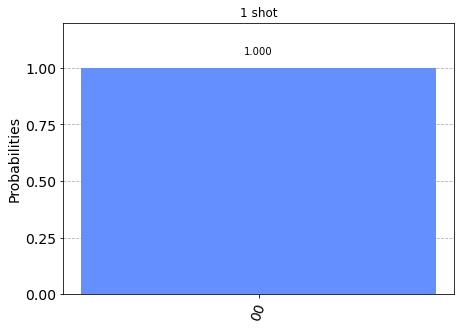

In [55]:
#  1 shot
circuit_1 = circuit(min_aqgd_costs[0])
counted_1 = counts(circuit_1, 1)
plot_histogram(counted_1, title="1 shot")

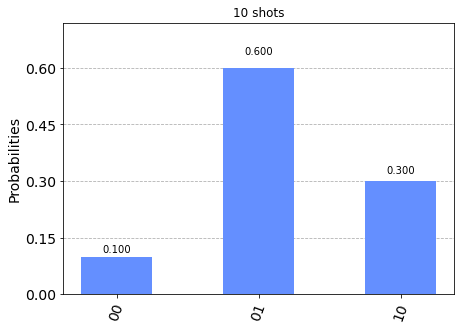

In [56]:
#  10 shots
circuit_10 = circuit(min_aqgd_costs[1])
counted_10 = counts(circuit_10, 10)
plot_histogram(counted_10, title="10 shots")

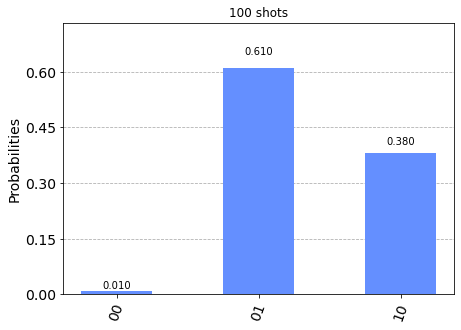

In [57]:
#  100 shots
circuit_100 = circuit(min_aqgd_costs[2])
counted_100 = counts(circuit_100, 100)
plot_histogram(counted_100, title="100 shots")

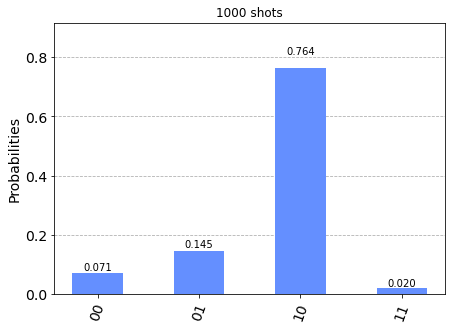

In [58]:
#  1000 shots
circuit_1000 = circuit(min_aqgd_costs[3])
counted_1000 = counts(circuit_1000, 1000)
plot_histogram(counted_1000, title="1000 shots")

## Adam Optimizer

In [33]:
optimizer2 = ADAM(maxiter=5000, tol=0.05, lr=0.5, beta_1=0.9, beta_2=0.999, noise_factor= 0.05) # with noise factor

# sampling
shots=[1,10,100,1000]

step_no = 120

min_adam_costs = []

for shot_no in shots:
    cost_obj = compute_cost()
    cost_obj.shot = shot_no
    
    print('Shot no: ',shot_no)
    
    adam_optimizer_costs = []
    minimum_cost = 1000000.0
    minimum_param = []
        
    for i in range(step_no):  
        init = np.random.rand(3)
        param = optimizer2.optimize(num_vars=3, objective_function=cost_obj.cost, initial_point=init)
        if (i+1)%20 ==0 and i:
            print('parameters: ',param[0],'cost: ',param[1],' after ',i+1,' iterations')
        adam_optimizer_costs.append(param)
        if param[1] <= 1.00:
            break
    
    
    for par in adam_optimizer_costs:
        if par[1] < minimum_cost:
            minimum_cost = par[1]
            minimum_param = list(par[0])
            
    min_adam_costs.append(minimum_param)

Shot no:  1
parameters:  [0.18377812 0.94864836 0.26516851] cost:  15000.0  after  20  iterations
parameters:  [0.56581125 0.2087881  0.06031984] cost:  15000.0  after  40  iterations
parameters:  [0.92954957 0.1584617  0.23064627] cost:  15000.0  after  60  iterations
parameters:  [0.64108347 0.16572915 0.66872313] cost:  15000.0  after  80  iterations
parameters:  [ 9.64408076  8.72689013 13.14306716] cost:  5000.0  after  100  iterations
parameters:  [ 2.26903592 -2.9713921   2.92390528] cost:  5000.0  after  120  iterations
Shot no:  10
parameters:  [-1.55580305 -1.34818909 -0.95384836] cost:  4600.0  after  20  iterations
parameters:  [-4.08237935  0.11220447 -3.71909269] cost:  3800.0  after  40  iterations
parameters:  [-3.69805300e+00  1.12433931e-03  1.22848786e+00] cost:  1800.0  after  60  iterations
parameters:  [4.66904069 5.27066727 0.04779814] cost:  5200.0  after  80  iterations
parameters:  [7.32896332 7.48755431 1.25845132] cost:  11800.0  after  100  iterations
Shot 

In [34]:
print(min_adam_costs)

[[-6.981867792483483, -6.312298567872027, -6.343457577129088], [2.946581027681215, 2.4747308732877134, 1.535691931233327], [3.26511498568945, 4.4792869689698085, 1.448871990290104], [9.378426195516214, 4.729397578829361, 2.4924318360740334]]


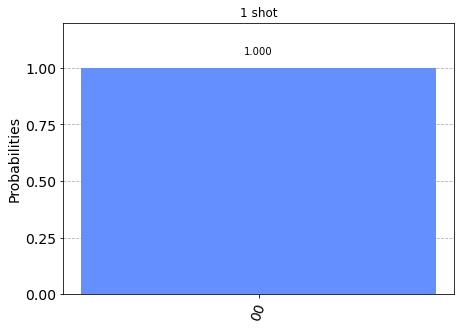

In [51]:
#  1 shot
circuit_1 = circuit(min_adam_costs[0])
counted_1 = counts(circuit_1, 1)
plot_histogram(counted_1, title="1 shot")

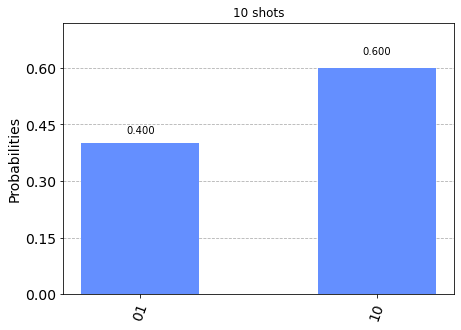

In [52]:
#  10 shots
circuit_10 = circuit(min_adam_costs[1])
counted_10 = counts(circuit_10, 10)
plot_histogram(counted_10, title="10 shots")

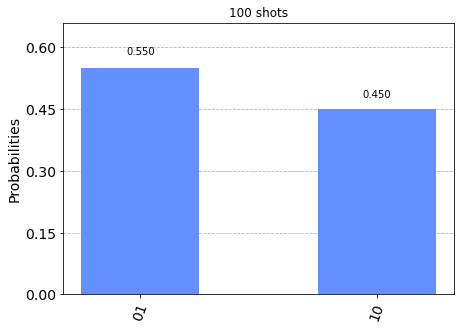

In [53]:
#  100 shots
circuit_100 = circuit(min_adam_costs[2])
counted_100 = counts(circuit_100, 100)
plot_histogram(counted_100, title="100 shots")

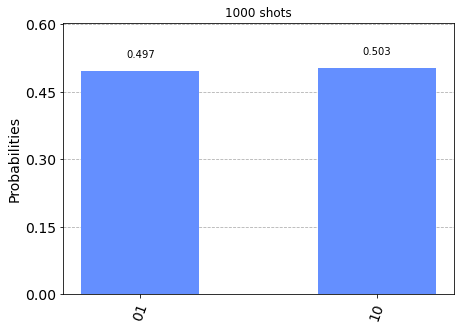

In [54]:
#  1000 shots
circuit_1000 = circuit(min_adam_costs[3])
counted_1000 = counts(circuit_1000, 1000)
plot_histogram(counted_1000, title="1000 shots")

## Nelder-Mead Optimizer

In [45]:
optimizer3 = NELDER_MEAD(maxfev=1000, disp=False, xatol=0.05, tol=0.05 )

# sampling
shots=[1,10,100,1000]

step_no = 120

min_nelder_mead_costs = []

for shot_no in shots:
    cost_obj = compute_cost()
    cost_obj.shot = shot_no
    
    print('Shot no: ',shot_no)
    
    nelder_mead_optimizer_costs = []
    minimum_cost = 1000000.0
    minimum_param = []
        
    for i in range(step_no):  
        init = np.random.rand(3)
        param = optimizer3.optimize(num_vars=3, objective_function=cost_obj.cost, initial_point=init)
        if (i+1)%20 ==0 and i:
            print('parameters: ',param[0],'cost: ',param[1],' after ',i+1,' iterations')
        nelder_mead_optimizer_costs.append(param)
        if param[1] <= 1.00:
            break
    
    
    for par in nelder_mead_optimizer_costs:
        if par[1] < minimum_cost:
            minimum_cost = par[1]
            minimum_param = list(par[0])
            
    min_nelder_mead_costs.append(minimum_param)

Shot no:  1
parameters:  [0.45025379 0.32253238 0.99677928] cost:  15000.0  after  20  iterations
parameters:  [0.40895492 0.48548414 0.22988848] cost:  15000.0  after  40  iterations
parameters:  [0.7155853  0.67139599 0.43116125] cost:  15000.0  after  60  iterations
parameters:  [0.09975439 0.26938496 0.76036863] cost:  15000.0  after  80  iterations
parameters:  [0.63090198 0.83217937 0.78578202] cost:  15000.0  after  100  iterations
parameters:  [0.03848793 0.14121448 0.51636594] cost:  15000.0  after  120  iterations
Shot no:  10
parameters:  [0.84529253 0.18208239 0.36202363] cost:  3200.0  after  20  iterations
parameters:  [0.32422051 0.4979405  0.932175  ] cost:  5400.0  after  40  iterations
parameters:  [0.60054537 0.7363537  0.19088869] cost:  4200.0  after  60  iterations
parameters:  [0.8673664  0.35144927 0.24028378] cost:  2600.0  after  80  iterations
parameters:  [0.35201488 0.55786233 0.45976615] cost:  6200.0  after  100  iterations
parameters:  [0.70331902 0.1230

In [46]:
print(min_nelder_mead_costs)

[[0.7910613697886832, 0.5995996450859095, 0.08674111053336207], [1.0573307718677798, 0.5980269473296067, 0.7398502148256029], [0.9964807146565593, 0.8821077539086315, 0.6680861742851278], [3.1684569637204847, -0.2162567383009176, 1.572825206756982]]


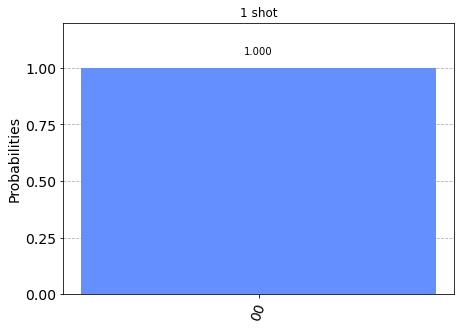

In [47]:
#  1 shot
circuit_1 = circuit(min_nelder_mead_costs[0])
counted_1 = counts(circuit_1, 1)
plot_histogram(counted_1, title="1 shot")

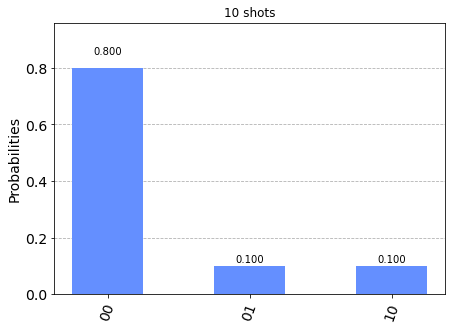

In [48]:
#  10 shots
circuit_10 = circuit(min_nelder_mead_costs[1])
counted_10 = counts(circuit_10, 10)
plot_histogram(counted_10, title="10 shots")

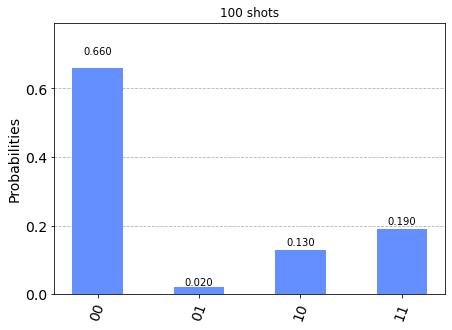

In [49]:
#  100 shots
circuit_100 = circuit(min_nelder_mead_costs[2])
counted_100 = counts(circuit_100, 100)
plot_histogram(counted_100, title="100 shots")

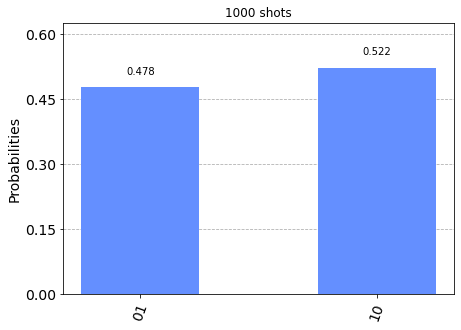

In [50]:
#  1000 shots
circuit_1000 = circuit(min_nelder_mead_costs[3])
counted_1000 = counts(circuit_1000, 1000)
plot_histogram(counted_1000, title="1000 shots")

## How to make sure we produce state $\lvert01\rangle$ + $\lvert10\rangle$ and not $\lvert01\rangle$ - $\lvert10\rangle$ ?


<i>Explanation:</i> At the beginning of this notebook, a circuit is shown having one Pauli $X$ operator on the second qubit and a $H$ gate on the first qubit. From theory it is known that, $H$ gate rotates  $\lvert0\rangle$ state to  $\lvert+\rangle$ state and $\lvert1\rangle$ to $\lvert-\rangle$ state. Also, Pauli $X$ gate flips  $\lvert0\rangle$ to $\lvert1\rangle$ and vice versa. 

So, initially both qubits are in $\lvert0\rangle$ state. Pauli $X$ gate flips $\lvert0\rangle$ to $\lvert1\rangle$. And applying $H$ gate creates possibility of $\frac{1}{2}$ $\lvert0\rangle$ state and $\frac{1}{2}$ $\lvert1\rangle$ state. And, when the first qubit represents $\lvert0\rangle$ state, applying $CX$ gate does not change the state of second qubit. So it becomes $\lvert01\rangle$. Similarly, when the first qubit is in $\lvert1\rangle$ state, the second qubit becomes $\lvert0\rangle$ after applying $CX$ gate. Here, as the $H$ gate rotates $\lvert0\rangle$ to $\lvert+\rangle$ state, the resulting state from the circuit becomes $\lvert01\rangle+\lvert10\rangle$.

Hence, the circuit that was experimented ensures that we produce only $\lvert01\rangle+\lvert10\rangle$ state.



From the circuit given below, the first qubit becomes $\lvert1\rangle$ after applying Pauli $X$ gate. And, $H$ gate rotates $\lvert1\rangle$ state into $\lvert-\rangle$ state. As a result the circuit state finally becomes $\lvert01\rangle-\lvert10\rangle$.

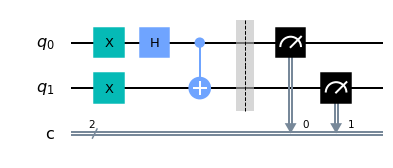

In [36]:
q = QuantumCircuit(2,2)

q.x(0)
q.h(0)
q.x(1)
q.cx(0,1)
q.barrier(range(2))
q.measure((0,1),(0,1))

q.draw('mpl')

{'01': 524, '10': 500}


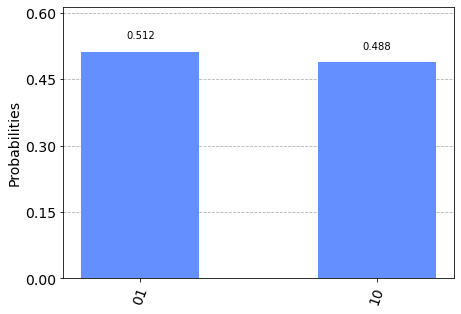

In [37]:
backend = Aer.get_backend('qasm_simulator')
job = execute(q, backend, shots= 1024)
result = job.result()
count = result.get_counts()
print(count)
plot_histogram(count)

[0.+0.0000000e+00j 0.+0.0000000e+00j 1.-1.2246468e-16j 0.+0.0000000e+00j]


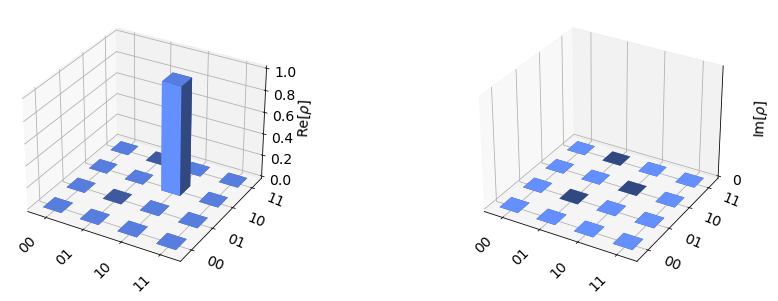

In [26]:
backend = Aer.get_backend('statevector_simulator')
job = execute(q, backend)
result = job.result()
state = result.get_statevector(q, decimals=3)
print(state)
plot_state_city(state)